### Variational Autoencoder

In [26]:
### importing modules that are needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn 
import torch.nn.functional as f 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split



In [41]:
### parameters for the problem and architecture
input_size = 576
latent_dim = 32
batch_size = 100
torch.manual_seed(128)
learning_rate = 0.001
num_epochs = 10
L = 24


##### **Loading the data**

In [42]:
data_f = pd.read_csv(\
    '~/ml_J1-J2_supervised/all_phase/af/augumented_dataL24.csv',index_col=[0])

X_train,X_test,y_train,y_test = train_test_split(data_f.iloc[:,:-1],data_f.iloc[:,-1:], \
                    random_state=42,test_size=0.2,stratify=data_f.iloc[:,-1:])

data_train = pd.concat([X_train,y_train],axis=1)
data_test = pd.concat([X_test,y_test],axis=1)



**Set the device**

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##### Class definition that is used to load the dataset.

In [44]:
### class to load the data
class LoadData(Dataset):
    def __init__(self,data,L,device=device):
        self.L = L
        self.x_data = torch.tensor(data.iloc[:,:-1].values,dtype=torch.float32).to(device=device)
        self.y_data = torch.tensor(data.iloc[:,-1:].values,dtype=torch.long).to(device=device)

    ### length of the dataset
    ### function one has to use if you want to define a custom dataset class
    def __len__(self):
        return len(self.y_data)

    
    ## get the image and label
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        
        image = self.x_data[idx,:]
        label = self.y_data[idx]

        return {'data':image,'label':label}

train_data = LoadData(data_train,L,device=device)
test_data = LoadData(data_test,L,device=device)

train_dataloader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_dataloader=DataLoader(test_data,batch_size=batch_size,shuffle=True)

##### **Model definition for the variational autoencoder**

In [45]:
### definition of the network
class encoder(nn.Module):
    
    def __init__(self,input_size,latent_dim):
        super(encoder,self).__init__()
        self.latent_dim = latent_dim
        self.input_size = input_size
        ### encoder network
        self.encoder1 = nn.Linear(in_features=self.input_size,out_features=256)
        self.encoder2 = nn.Linear(in_features=256,out_features=128)
        self.encoder3 = nn.Linear(in_features=128,out_features=64)
        self.encoder4 = nn.Linear(in_features=64,out_features=32)

        ### layer for mu_x and simga_x
        self.mux = nn.Linear(in_features=32,out_features=self.latent_dim)
        self.varx = nn.Linear(in_features=32,out_features=self.latent_dim)

        ## normal distribution       
        self.N = torch.distributions.Normal(0,1)

        self.kl = 0

    ### feedforward network 
    def forward(self,x):
        ##  passing the input through the network
        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)
        x = self.encoder4(x)

        ## passing input x to layer mu and var, mux = g(x), sigmax = f(x) 
        mu = self.mux(x)
        sigma = torch.exp(self.varx(x))

        ## combining mu and sigma to a normal distribution reparameterization trick
        ##  z = mu + sigma * N(0,1)
        zi = mu + sigma * self.N.sample(sigma.shape)
        
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1./2).sum()
        return zi



### definition of the network
class decoder(nn.Module):

    def __init__(self, input_size, latent_dim):
        super(decoder, self).__init__()
        self.latent_dim = latent_dim
        self.input_size = input_size
       
        ### decoder network
        self.decoder1 = nn.Linear(in_features=self.latent_dim, out_features=32)
        self.decoder2 = nn.Linear(in_features=32, out_features=64)
        self.decoder3 = nn.Linear(in_features=64, out_features=128)
        self.decoder4 = nn.Linear(in_features=128, out_features=self.input_size)

    ### feedforward network
    def forward(self, x):
        ##  passing the input through the network
       
        x = self.decoder1(x)
        x = self.decoder2(x)
        x = self.decoder3(x)
        x = self.decoder4(x)

        return torch.sigmoid(x)


### class to implement encoder-decoder network
### it used encoder-decoder classes defined previouly
class VariationalAutoencd(nn.Module):
    def __init__(self,input_size,latent_dim):
        super(VariationalAutoencd,self).__init__()
        self.encoder = encoder(input_size,latent_dim)
        self.decoder = decoder(input_size,latent_dim)
    
    ### feedforward network
    def forward(self,x):
        z = self.encoder(x)
        xp = self.decoder(z)
        return xp

### Steps of the process
* Pass the input $X$ through the encoder stage $x_enc$
* To get estimate of $\mu$ and $\sigma$ use two neural network and pass $x_enc$ through both of them
    * $\mu_{x} = f_{2}(f_{1}(x))$
    * $\sigma_{x} = g_{2}(f_{1}(x))$
    * Network $f_{1}(x)$ represents the input that is passed through various stages (neural network) and $f_{2},g_{2}$ represents two different neural network.
* To generate the distribution $q(z|x)$ use $\mu_{x},\sigma_{x}$ to generate a normal distribution.
    * $q(z|x) = \mathcal{N}(\mu_{x},\sigma_{x})$
    * Sample a point from this distribution $q(z|x)$
    * Directly sampling from $q(z|x)$ is not possible
    * However this doesn't allow for back progagation so we use reparameterization trick
        * $z \sim  \mu_{x} + \sigma_{x} \mathcal{N}(0,I)$
* Now using $z$ we have to generate $p(x|z)$.
* The error one is trying to minimize is 
\begin{equation}
min E_{q} \left [ \log q(z|x) - \log p(z) \right ] -  {E}_{q} \log p(x|z) 
\end{equation}
* Here $E_{q}$ means average value for a given distribution of $q(z|x)$
* Distribution $p(z) = \mathcal{N} (0,1)$ is a standard normal.
* Distribution $p(x|z) = \mathcal{N}(f(z),cI) = \mathcal{N} (decoder(z),cI)$ 

#### KL-divergence
\begin{equation}
KL\left[q(z|x),p(z)\right] = \log\left[q(z|x)/p(z)\right]
\end{equation}
* The distribution $q(z|x) \sim \mathcal{N}(\mu_{x},\sigma_{x}) \equiv \exp\left(-\frac{(x-\mu_{x})^{2}}{2\sigma_{x}^{2}}\right)$
* The distribution $p(z) \sim \mathcal{N}(0,1) \equiv \exp\left(-\frac{z^{2}}{2}\right)$

\begin{eqnarray}
\frac{q(z|x)}{p(z)} = \exp \left( -\frac{(x-\mu_{x})^{2}}{2 \sigma_{x}^{2}} + \frac{z^{2}}{2}\right)
\end{eqnarray}

In [48]:
### define the training function
def train(model,device,dataloader,optimizer):
    ## set train mode for encoder and decoder
    model.train()
    loss_train = 0.0 
    for batch_idx,batch in enumerate(dataloader):
        x=batch['data'].to(device=device)

        ## pass the data through the network
        xnew = model(x)

        ## calculate the loss (reconstruction loss) and (kl divergence)
        loss = model.encoder.kl + ((x-xnew)**2).sum()

        ## backward pass
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        loss_train += loss.item()
    print(loss_train/len(dataloader.dataset))
    return loss_train/len(dataloader.dataset)

### define the training function
def test(model, device, dataloader):
    ## set train mode for encoder and decoder
    model.eval()

    loss_test = 0.0
    for batch_idx, batch in enumerate(dataloader):
        x = batch['data'].to(device=device)

        ## pass the data through the encoder network
        z = model.encoder(x)

        ## get the reconstructed data by passing the data through the network
        xp = model(x)

        ## calculate the loss (reconstruction loss) and (kl divergence)
        loss = model.encoder.kl + ((x-xp)**2).sum()
    
        loss_test += loss.item()
    print(loss_test/len(dataloader.dataset))
    return loss_test/len(dataloader.dataset) 



In [49]:

### create an instance of variational autoencoder
vae = VariationalAutoencd(input_size, latent_dim)

### set the optimizer with the necessary parameter
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    train_loss = train(vae,device,train_dataloader,optimizer)
    test_loss = test(vae,device,test_dataloader)

461.41395263671876
448.1426105957031
447.7383325805664
447.58103271484373
446.924499206543
446.43195532226565
445.44725799560547
445.18704614257814
445.318270690918
445.32517724609374
445.42853662109377
445.16392602539065
445.39634088134767
445.4123010253906
2.0851368886971505e+18
1.7970047474592646e+17
1.1817774894744915e+17
7.9819833765645e+16
5.8637172578520664e+16
4.371264424768019e+16


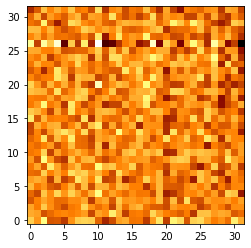

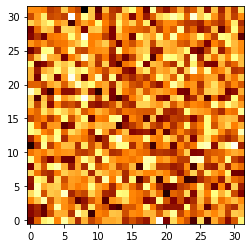

In [63]:
plt.imshow(vae.encoder.mux.weight.data.numpy(),origin='lower',cmap='afmhot')

In [ ]:
vae.eval()
latent=torch.random(12)